# Test finding conserved quantities in Neumann model

In [ ]:
import numpy as np
import tensorflow as tf
import sys
sys.path.append("../")
import os

from models import *
from hamiltonians import parameterized_neumann
from utils import make_train_op
from losses import make_loss
from data import make_data
from utils import visualize_chain_bijector, is_symplectic

DTYPE=tf.float32
NP_DTYPE=np.float32

In [ ]:
tf.set_random_seed(0)

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Settings

In [5]:
frequencies = [.1, .2, .3]
settings = {
    'frequencies': frequencies,
    'hamiltonian': parameterized_neumann(frequencies),
    'd': 3,                    # space dimension
    'num_particles': 1,        # number of particles
    'minibatch_size': 2**7,    # Mini batch size
    'dataset_size': 2**13,      # Set to float("inf") for keeping sampling.
    'num_stacks_bijectors': 4, # Number of bijectors
    'log_dir' : "/tmp/log/im_tests/neumann-3/with-grad-clip",
    'ckpt_freq': 1000,
    'train_iters': 2,
    'visualize': True,
#    'grad_clip_norm': 1e-10, # clip norm to val. Comment for no gradient clipping
    'starter_learning_rate': 0.00001,    
    'decay_lr': "piecewise",
    'boundaries': [20000, 200000], # for piecewise decay
    'values': [1e-5, 1e-6, 1e-6],  # for piecewise decay
    'min_learning_rate': 1e-6,   
#     'decay_steps': 25000,  # ignored if decay_lr False
#     'decay_rate': 0.5,     # ignored if decay_lr False (decayed_learning_rate = learning_rate *
#                            #                            decay_rate ^ (global_step / decay_steps))
    'loss': "dKdphi",
    'base_dist': "action_dirac_angle",
#    'value_actions': [0.1324, 0.0312, 0.2925],
#    'elastic_net_coeff': 1.
    }
# Choose a batch of actions: needs to be divisor of dataset_size or minibatch_size if infinite dataset
r = np.random.RandomState(seed=0)
num_samples_actions = 2 # number of distinct actions (Liouville torii)
sh = (num_samples_actions, settings['d'], settings['num_particles'], 1)
settings['value_actions'] = r.rand(*sh).astype(NP_DTYPE)
print(settings['value_actions'])

[[[[0.5488135 ]]

  [[0.71518934]]

  [[0.60276335]]]


 [[[0.5448832 ]]

  [[0.4236548 ]]

  [[0.6458941 ]]]]


Define the model T as sequence of symplectic transformations 

In [6]:
# To account for periodicity start with oscillator flow
stack = [OscillatorFlow()] 
for i in range(settings['num_stacks_bijectors']):
    stack.extend([ZeroCenter(),
                  LinearSymplecticTwoByTwo(),
                  SymplecticAdditiveCoupling(shift_model=IrrotationalMLP())])
                  #SymplecticAdditiveCoupling(shift_model=MLP())])
T = Chain(stack)

Data, loss and train op:

In [7]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)

z = make_data(settings, sess)

loss = make_loss(settings, T, z)

train_op = make_train_op(settings, loss, step)

Instructions for updating:
Colocations handled automatically by placer.
In DiracDistribution constructor: actions =  [[[[0.5488135 ]]

  [[0.71518934]]

  [[0.60276335]]]


 [[[0.5448832 ]]

  [[0.4236548 ]]

  [[0.6458941 ]]]]
Instructions for updating:
Use tf.cast instead.


Visualize before training: T is very close to identity, so circles are mapped to circles.

In [8]:
sess.run(tf.global_variables_initializer())

In [9]:
#visualize_chain_bijector(T, z, sess=sess)

## Train

In [10]:
# Set the ZeroCenter bijectors to training mode:
for i, bijector in enumerate(T.bijectors):    
    if hasattr(bijector, 'is_training'):
        T.bijectors[i].is_training = True

In [11]:
tf.contrib.training.train(train_op, logdir=settings['log_dir'], save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/log/im_tests/neumann-3/with-grad-clip/model.ckpt.
INFO:tensorflow:global_step/sec: 46.3398
INFO:tensorflow:global_step/sec: 101.896
INFO:tensorflow:global_step/sec: 108.742
INFO:tensorflow:global_step/sec: 110.728
INFO:tensorflow:global_step/sec: 113.43
INFO:tensorflow:global_step/sec: 111.018
INFO:tensorflow:global_step/sec: 114.445
INFO:tensorflow:global_step/sec: 114.982
INFO:tensorflow:global_step/sec: 114.397
INFO:tensorflow:global_step/sec: 115.473
INFO:tensorflow:global_step/sec: 116.322
INFO:tensorflow:global_step/sec: 114.817
INFO:tensorflow:global_step/sec: 115.096
INFO:tensorflow:global_step/sec: 114.847
INFO:tensorflow:global_step/sec: 110.089
INFO:tensorflow:global_step/sec: 113.178
INFO:tensorflow:global_step/sec: 101.092
INFO:tensorflow:global_step/sec: 90.728

KeyboardInterrupt: 

## Test

In [22]:
# Load the latest parameters
saver = tf.train.Saver()
ckpt_state = tf.train.get_checkpoint_state(settings['log_dir'])
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from /tmp/log/im_tests/neumann-3/with-grad-clip/model.ckpt-6691


In [18]:
# Set the ZeroCenter bijectors to prediction mode:
for i, bijector in enumerate(T.bijectors):    
    if hasattr(bijector, 'is_training'):
        T.bijectors[i].is_training = False

In [19]:
# Test accuracy on new minibatch
print("Test error: ", sess.run(loss))

Test error:  0.47978628


In [20]:
zz = tf.expand_dims(z[0,:,:,:],0)
x = zz
for i, bijector in enumerate(T.bijectors):        
    print(i, is_symplectic( bijector, x, sess=sess, rtol=1e-06, atol=1e-06))
    x = bijector(x)
print("Full flow:")
is_symplectic( T, zz, sess=sess, rtol=1e-06, atol=1e-06 )

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
Full flow:


True

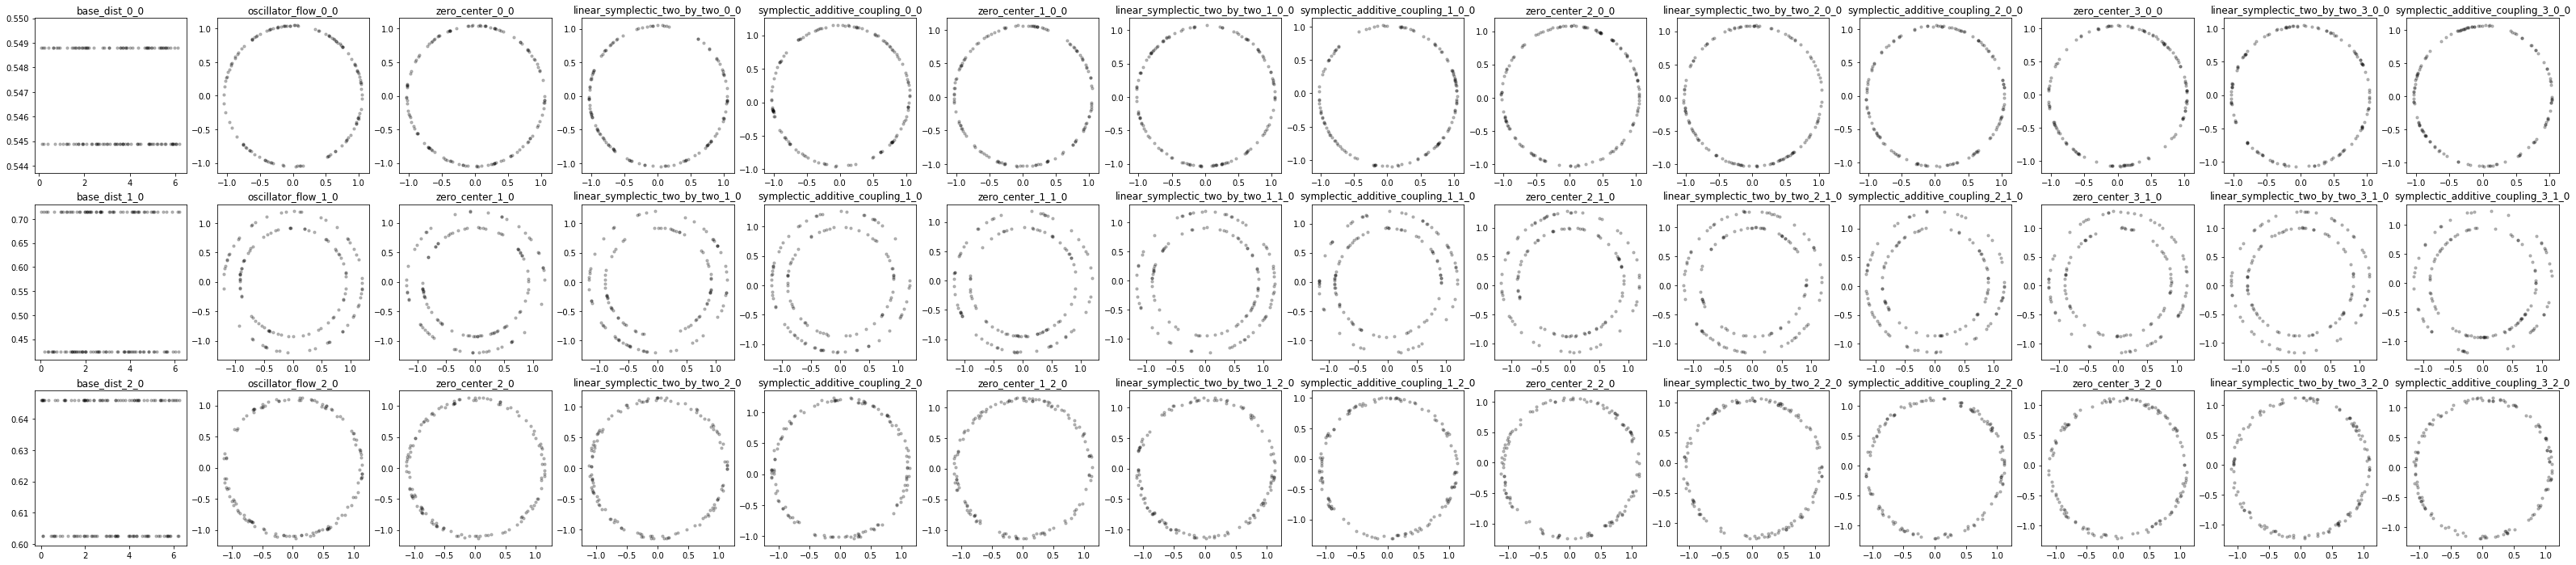

In [21]:
visualize_chain_bijector(T, z, sess=sess)

### Visualize after training - to be removed, old experiment, kept because of nice shapes...

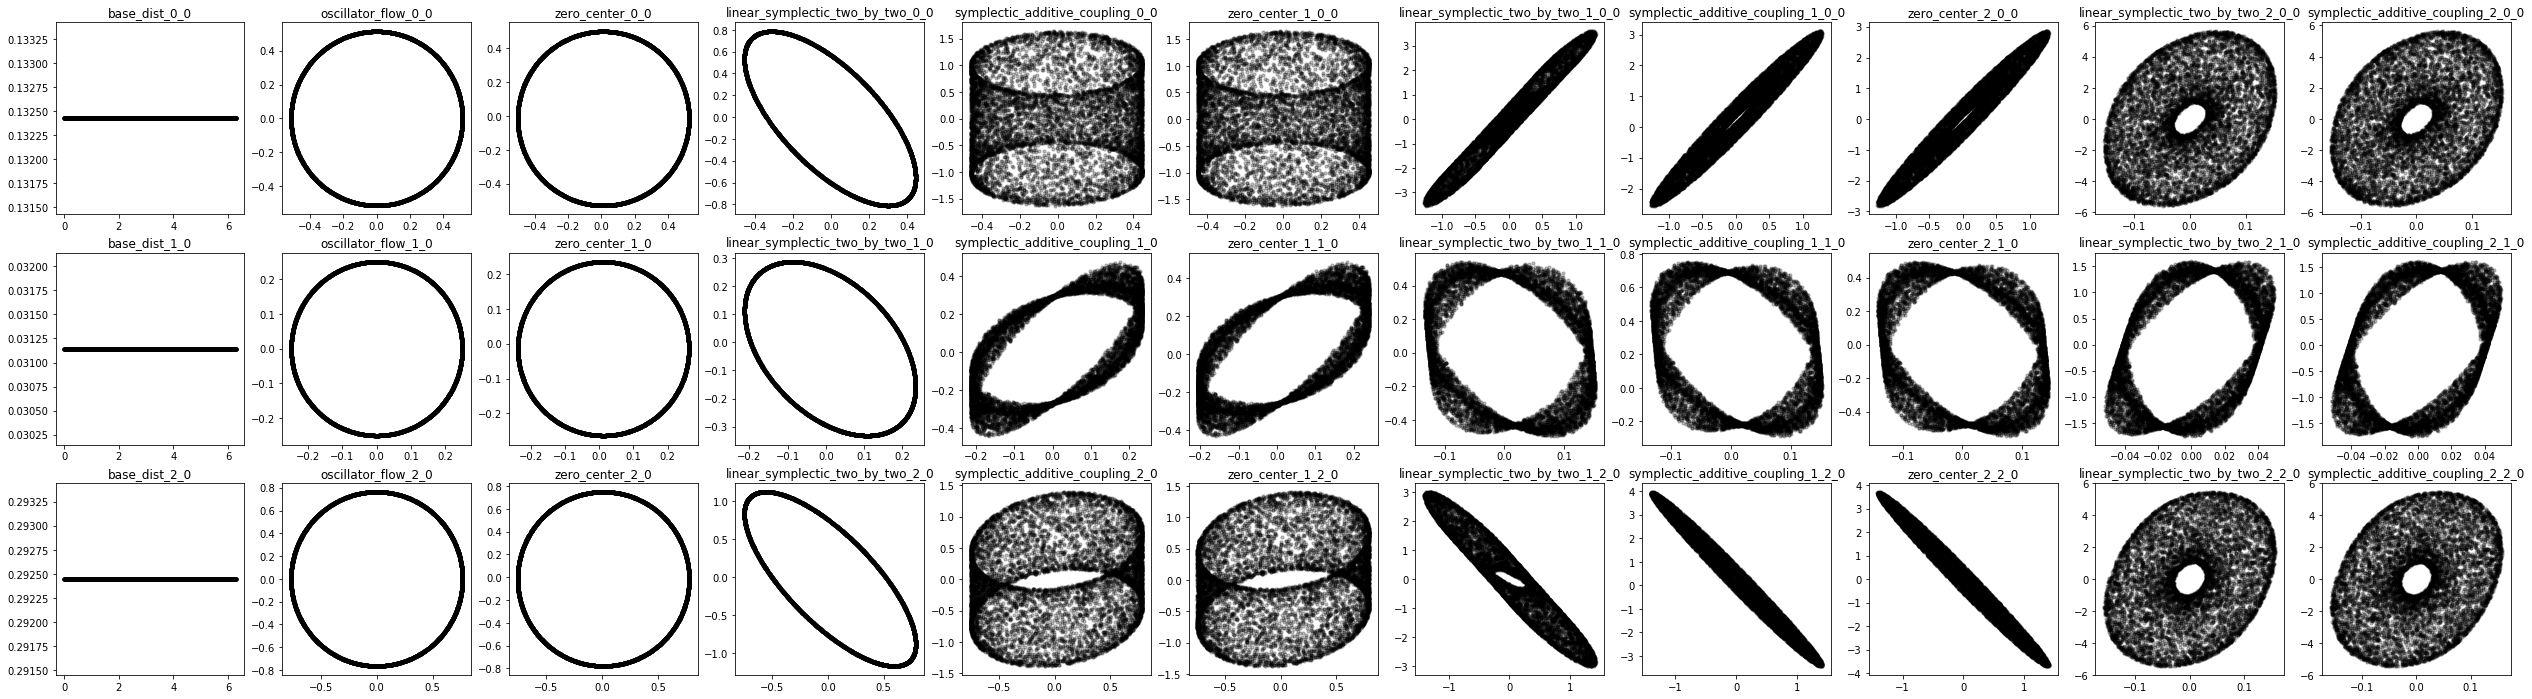

In [16]:
visualize_chain_bijector(T, z, sess=sess)

In [22]:
plt.savefig("viz_bij_neumann_fixed_batch.png")

<Figure size 432x288 with 0 Axes>

## Look at the Learned Representation

Try directly integrating the eom of the transformed Hamiltonian

In [12]:
import matplotlib.pyplot as plt

In [13]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(lambda z : settings['hamiltonian'](T(z)),
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
# 1 random initial condition (scale it back so that the motion is in the sampled region)
z0 = sess.run( tf.expand_dims(z[3,:,:,:],0) )
print(z0)
#x0 = tf.reshape([1.,0.2,1.,0.3,1.,0.4],[1,3,1,2])

[[[[1.8144529  0.1324    ]]

  [[6.246368   0.0312    ]]

  [[0.76288354 0.2925    ]]]]


In [14]:
traj = sess.run( integrator(z0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
phi_traj, I_traj = extract_q_p( traj )

Visualize: the transformed trajectories

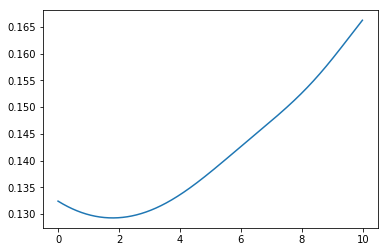

In [15]:
ts = np.arange(0.,10.,.01)

plt.plot(ts, I_traj[:,0,0,0])

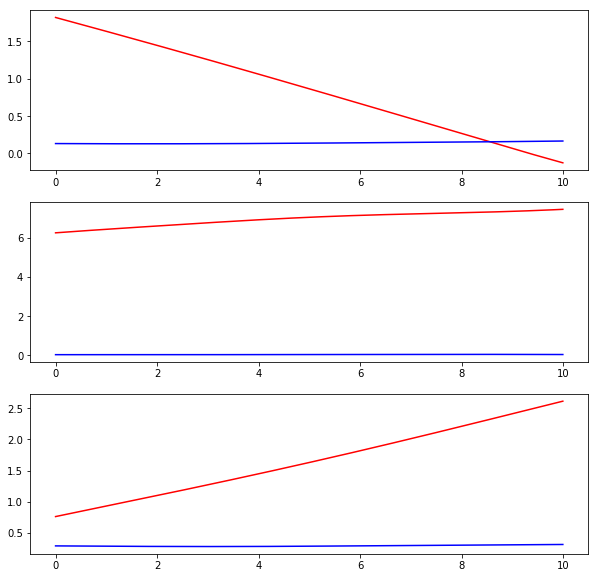

In [16]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        plt.plot(ts, phi_traj[:,d,n,0],'r')
        plt.plot(ts, I_traj[:,d,n,0],'b')
        #plt.gca().set_aspect('equal', adjustable='box')

Looks pretty good: visually, the angles (red) evolve linearly with time, while the actions (blue) are constant

Trajectories of original Hamiltonian

In [17]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=100., 
                             num_steps=1000)
# Map to original phase space the initial point
x0 = sess.run( T(z0) )
print(x0)

[[[[ 0.02485632 -3.0419567 ]]

  [[-0.0393815   0.76162225]]

  [[ 0.04966424 -0.16638938]]]]


In [18]:
x0[:,:,:,1]

array([[[-3.0419567 ],
        [ 0.76162225],
        [-0.16638938]]], dtype=float32)

In [19]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
qtraj, ptraj = extract_q_p( traj )

Visualize: the transformed trajectories

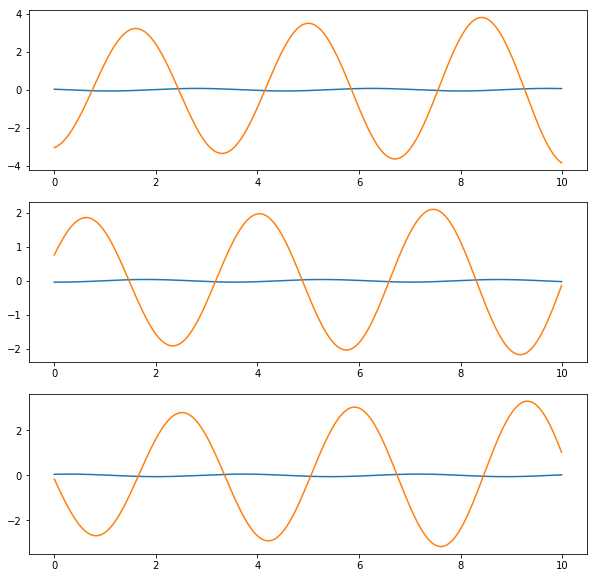

In [20]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        plt.plot(ts, qtraj[:,d,n,0])
        plt.plot(ts, ptraj[:,d,n,0])
        #plt.gca().set_aspect('equal', adjustable='box')

Map back to action/angle: we do not want all the way to I,phi; only till the cartesian coordinates in the action angle plane

In [21]:
# stop_at 1: do not run the inverse oscillator bijector which folds on upper half plane only.
ind_to_stop = 1
trans_traj = sess.run(T.inverse(tf.constant(traj), stop_at=ind_to_stop)) 
#phi_trans_traj,I_trans_traj = extract_q_p(trans_traj)

In [23]:
if ind_to_stop == 0:
    osc_traj = T.bijectors[0](tf.constant(trans_traj))
else:
    osc_traj = tf.constant( trans_traj )
q_osc_traj,p_osc_traj = sess.run(extract_q_p(osc_traj))

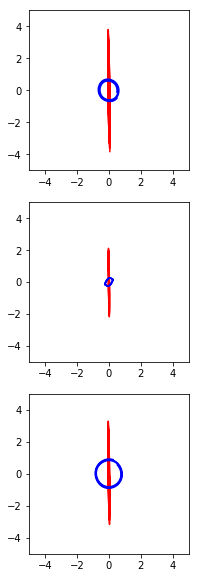

In [24]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0],'r')
        plt.plot(q_osc_traj[:,d,n,0], p_osc_traj[:,d,n,0],'b')
        plt.xlim(-5, 5)
        plt.ylim(-5, 5)
        #plt.plot(ts, xtraj[:,d,n,0])
        #plt.plot(ts, ytraj[:,d,n,0])
        
        plt.gca().set_aspect('equal', adjustable='box')

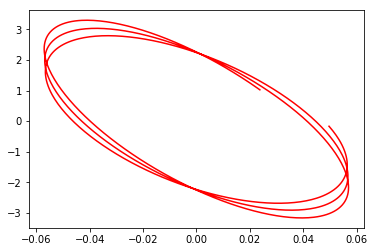

In [25]:
dd = 2; nn = 0
plt.plot(qtraj[:,dd,nn,0], ptraj[:,dd,nn,0],'r')

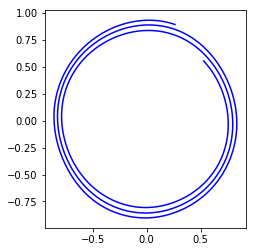

In [26]:
plt.plot(q_osc_traj[:,dd,nn,0], p_osc_traj[:,dd,nn,0],'b')
plt.gca().set_aspect('equal', adjustable='box')

## Conclusions

The circles in the transformed plane look pretty good.